## Ejercicios de pair programming 31 enero: Decision Tree

In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

### Info columnas
|Column| Type | Description |
|-------|--------------|-------------|
|distance_from_home| float64|	The distance from home where the transaction happened
|distance_from_last_transaction| float64|	The distance from last transaction happened.
|ratio_to_median_purchase_price| float64|	Ratio of purchased price transaction to median purchase price.
|repeat_retailer| float64|	Is the transaction happened from same retailer. 
|used_chip| float64|	Is the transaction through chip (credit card)
|used_pin_number| float64|	Is the transaction happened by using PIN number. 
|online_order | float64| Is the transaction an online order.
|fraud | float64| Is the transaction fraudulent.   

Enlace del *DataFrame* *[card_transdata](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud)*

In [ ]:
df = pd.read_csv("card_transdata_balanceado.csv", index_col = 0) #Usamos solo los datos balanceados ya que sabemos que nos dan mejor resultado en la predición
df.head(2)

,repeat_retailer,used_chip,used_pin_number,online_order,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,fraud
995934,0,0,0,1,-0.398964,-0.176219,-0.493696,0
665555,1,0,0,1,-0.123435,-0.143533,0.579227,0


In [ ]:
# separamos los datos en X e y
X1 = df.drop("fraud", axis = 1)
y1 = df["fraud"]

In [ ]:
# separamos en train y test
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [ ]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

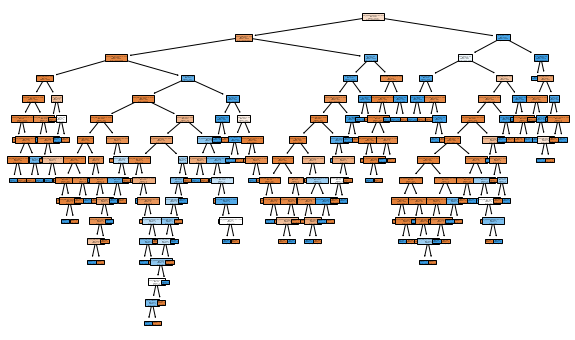

In [ ]:
#Representamos el arbol
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train1.columns, filled = True)
plt.show()

In [ ]:
# Como vemos, debemos poner en nuestro modelo unas features máximas de 3. 
max_features = np.sqrt(len(x_train1.columns))
max_features

2.6457513110645907

In [ ]:
#Vemos cual ha sido la profunidad de nuestro arbol para poder modificar hiperparámetros
print(arbol.tree_.max_depth)

13


In [ ]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [ ]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kappa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [ ]:
# sacamos las métricas
dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree I")
dt_results1

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.999908,0.999895,0.999888,0.999891,0.999812,test,Decission Tree I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree I


Podemos ver que nuestro modelo está overfitting por lo cual volvemos a hacer calculos para acercarnos a un modelo funcional.

In [ ]:
param = {"max_depth": [4,6,8], # teniendo en cuenta que teníamos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 13.
        "max_features": [1,2,3], # la raiz cuadrada es 2,6 por esto decidimos en tener 1,2,3.
        "min_samples_split": [0.1, 0.25, 0.35], #Como tenemos muchos datos decidimos poner los minimos en porcentaje
        "min_samples_leaf": [0.1, 0.25, 0.35]} 

In [ ]:
gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), 
            param_grid= param, 
            cv=10, 
            verbose=-1) 


In [ ]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [0.1, 0.25, 0.35],
                         'min_samples_split': [0.1, 0.25, 0.35]},
             verbose=-1)

In [ ]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=4, max_features=1, min_samples_leaf=0.1,
                       min_samples_split=0.1, random_state=42)

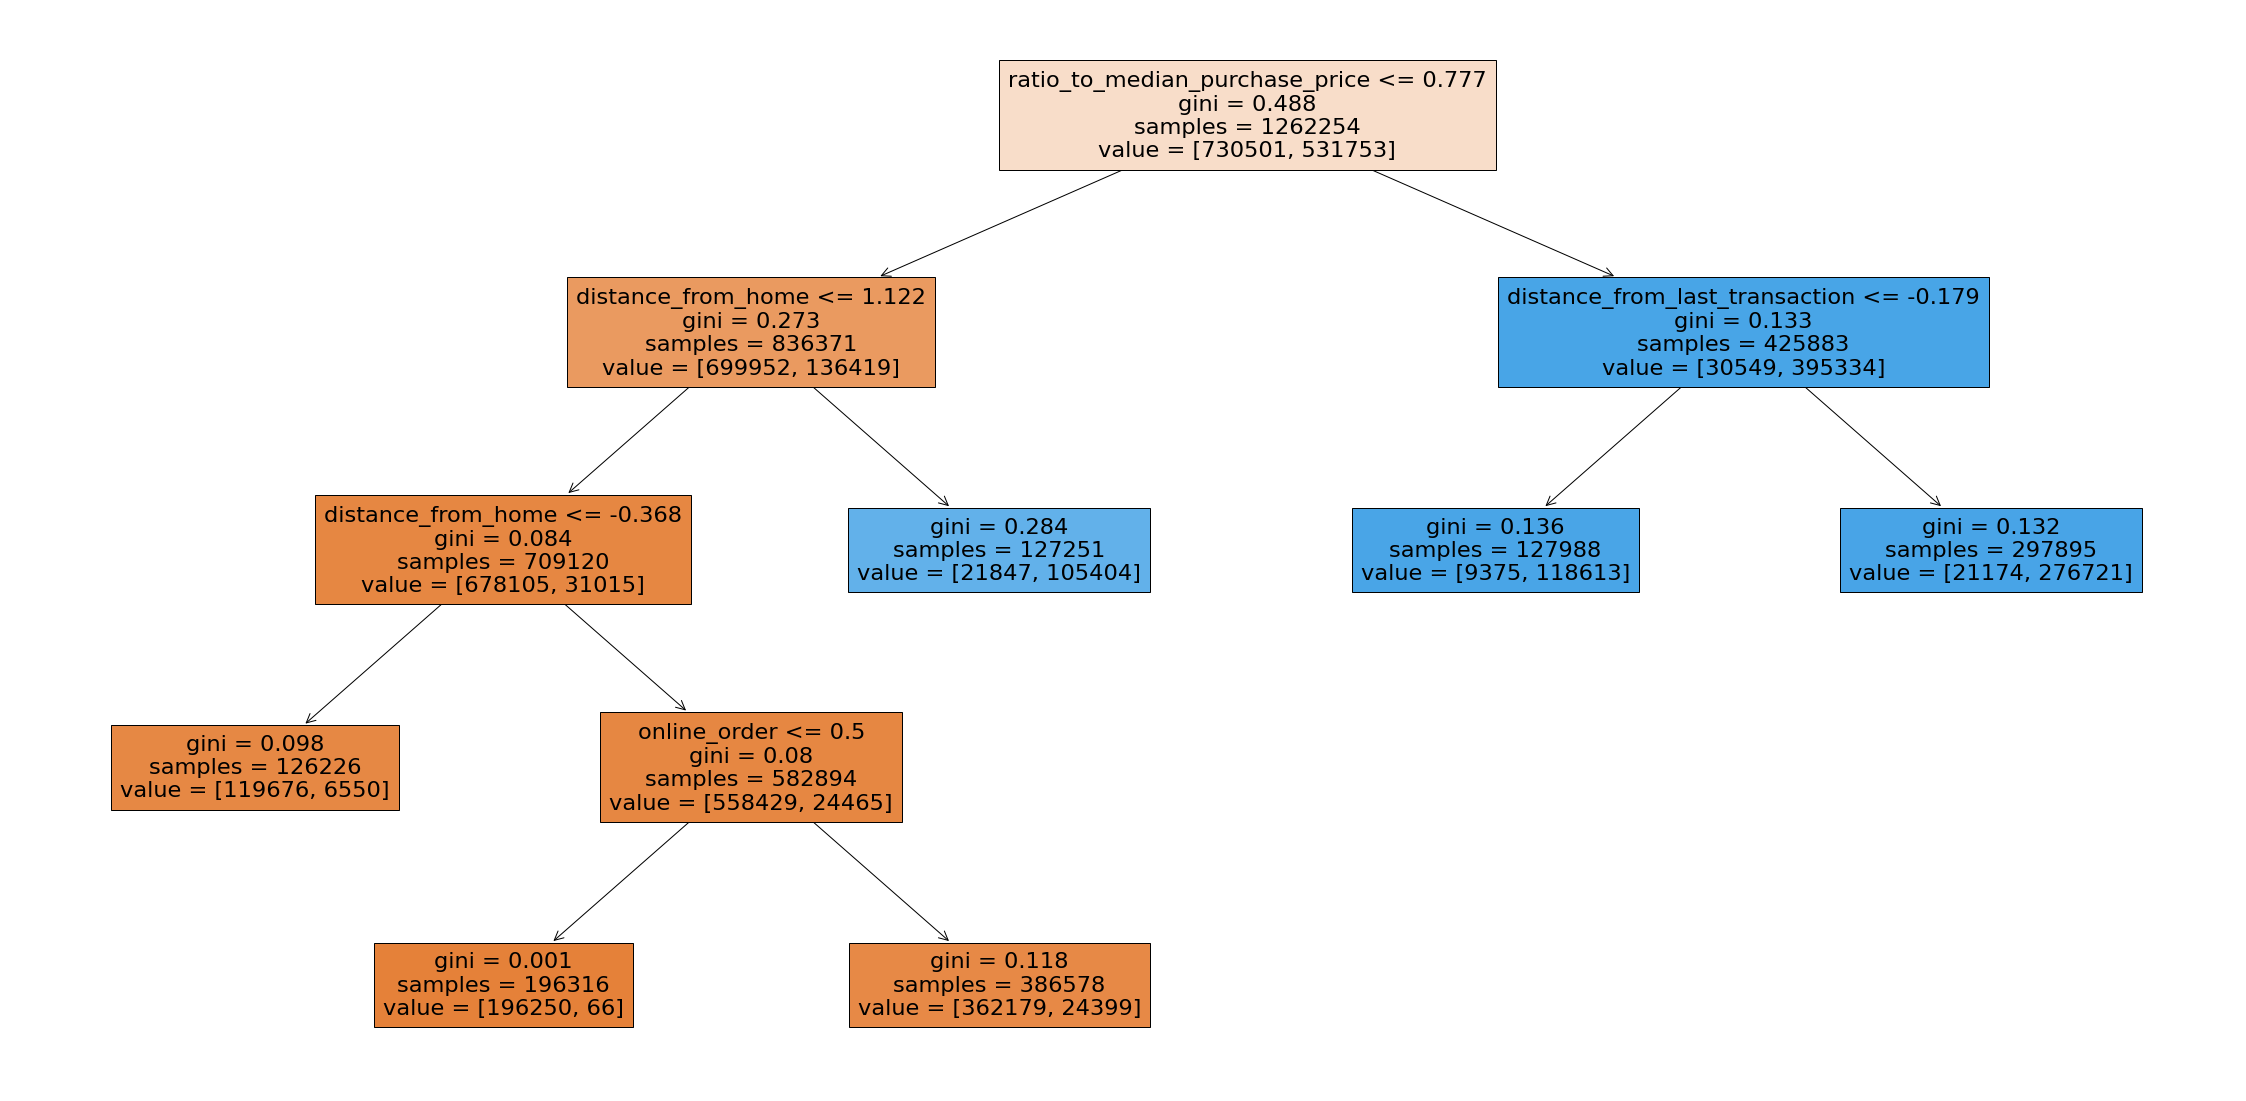

In [ ]:
#Representamos nuestro arbol ajustado con los hiperparámetros seleccionados por el best_estimator
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train1.columns, filled=True);

In [ ]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [ ]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision Tree II")
dt_results2

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
1,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


In [ ]:
# juntamos los dos modelos para compararlos.
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.999908,0.999895,0.999888,0.999891,0.999812,test,Decission Tree I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree I
0,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
1,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


Vemos los resultados de nuestro modelo. El *kappa* es de un 86% y el *recall*, que en nuestro caso es lo que más nos interesa (bajar los falsos negativos) es de un 94% que para ser la primera aproximación de nuestro modelo nos parece un valor muy bueno.


In [ ]:
df_logistic_results = pd.read_csv("resultados_fraude.csv", index_col = 0)
df_logistic_results

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.958645,0.891097,0.599037,0.716446,0.695063,test,Regresión logistica Estandarizados
1,0.958769,0.893075,0.600400,0.718060,0.696737,train,Regresión logistica Estandarizados
0,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
1,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados


In [ ]:
# Concatenamos todos los resultados de los análisis de regresión logística
df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.958645,0.891097,0.599037,0.716446,0.695063,test,Regresión logistica Estandarizados
1,0.958769,0.893075,0.600400,0.718060,0.696737,train,Regresión logistica Estandarizados
2,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
3,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados
4,0.999908,0.999895,0.999888,0.999891,0.999812,test,Decission Tree I
5,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree I
6,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
7,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


In [ ]:
df_DT_LR_results.drop([0,1,4,5], axis = 0, inplace = True) #Entre todos los modelos estos dos son los mejores resultados. 
df_DT_LR_results

,accuracy,precision,recall,f1,kappa,set,modelo
2,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
3,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados
6,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
7,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


In [ ]:
df_DT_LR_results.style.background_gradient(cmap='seismic')

,accuracy,precision,recall,f1,kappa,set,modelo
2,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
3,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados
6,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
7,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


Podemos ver la comparación del modelo de regresión logística y de *decision tree*. A pesar de que los valores generales de *Decision Tree* son ligerísimamente menores, el aumento de recall que en nuestro caso es el ajuste más significativo. Con lo cual consideramos que en nuestro caso de estudio el *Decision Tree* es el mejor modelo para la predicción del fraude. 

In [ ]:
df_DT_LR_results.to_csv("resultados_fraude_LR_DT.csv") #Guardamos para futuras comparaciones

In [ ]:
# Vamos a ver cuales son las variables que más influyen en nuestro modelo
importancia_predictores_esta = pd.DataFrame(
                            {'predictor': x_train1.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )

# ordenamos de mayor a menor los resultados
importancia_predictores_esta.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_esta

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,ratio_to_median_purchase_price,0.711667
4,distance_from_home,0.286121
3,online_order,0.002210
5,distance_from_last_transaction,0.000002
0,repeat_retailer,0.000000
1,used_chip,0.000000
2,used_pin_number,0.000000


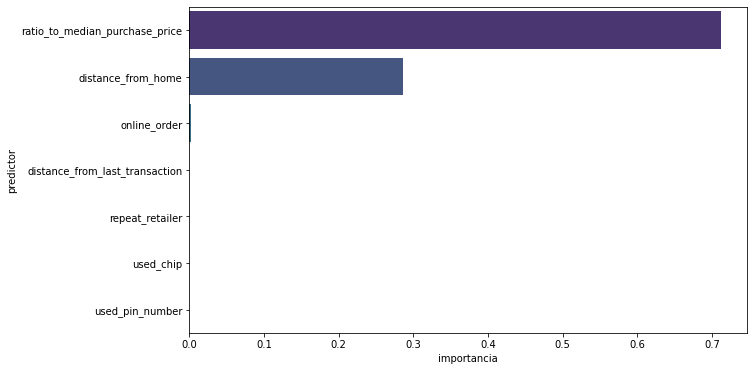

In [ ]:
#Representamos la importancia
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_esta, palette="viridis");
plt.show()

Los valores más importantes en el *Decision Tree* son el ratio medio del precio muy por encima del resto. Además la otra variable con importancia es la distancia de la transacción de casa. 
